Using device: cpu
File: Nautico_test1.jpeg, Predicted: nautico, Confidence: 32.17%
File: Nautico_test2.jpeg, Predicted: nautico, Confidence: 46.91%
File: Nautico_test3.jpeg, Predicted: nautico, Confidence: 36.45%


c:\Users\Eduardo Angelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Eduardo Angelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


File: Nautico_test4.jpg, Predicted: sport, Confidence: 76.40%
File: Nautico_test5.jpg, Predicted: sport, Confidence: 58.75%
File: Sport_test1.jpeg, Predicted: sport, Confidence: 79.69%
File: Sport_test3.jpeg, Predicted: sport, Confidence: 63.57%
File: Sport_test4.jpeg, Predicted: sport, Confidence: 57.63%
File: Sport_test5.jpeg, Predicted: sport, Confidence: 65.50%
File: Sport_test6.jpg, Predicted: sport, Confidence: 87.53%
Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
F1 Score: 0.8333

Classification Report:
              precision    recall  f1-score   support

     nautico       1.00      0.60      0.75         5
       sport       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



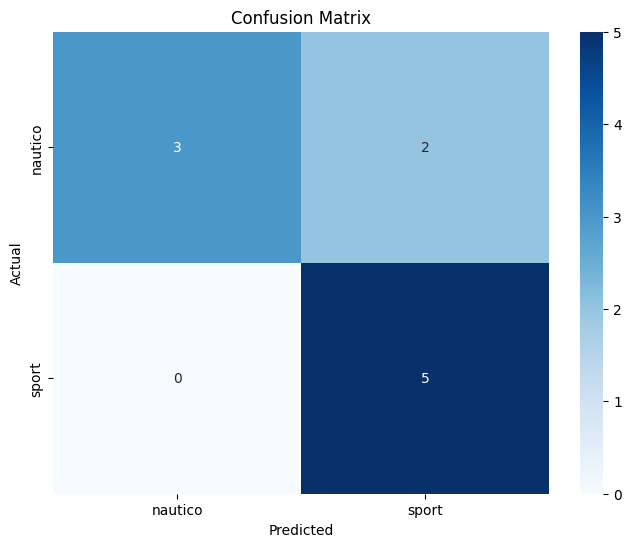

In [7]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Definir transformações para os dados de validação
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Verificar se CUDA está disponível
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_model(model_path):
    # Carregar o modelo EfficientNet pré-treinado
    model = models.efficientnet_b0(pretrained=False)
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1)
    )
    # Carregar os pesos do modelo treinado
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    return model

def evaluate_new_images(model, data_dir, transform):
    model.eval()
    new_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(new_dataset, batch_size=1, shuffle=False)
    
    all_preds = []
    all_labels = []
    file_names = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = probs.round()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Obter o nome do arquivo
            path = dataloader.dataset.samples[len(all_preds)-1][0]
            file_name = os.path.basename(path)
            file_names.append(file_name)
            # Exibir o resultado para cada imagem
            label_idx = int(preds.item())
            label_name = new_dataset.classes[label_idx]
            confidence = probs.item() * 100  # Converter para porcentagem
            print(f'File: {file_name}, Predicted: {label_name}, Confidence: {confidence:.2f}%')

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=new_dataset.classes))

    # Plot da matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=new_dataset.classes, yticklabels=new_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Caminho para o arquivo salvo do modelo
model_path = 'modelo_camisas_sport_nautico.pth'

# Carregar o modelo
model = load_model(model_path)

# Diretório contendo novas imagens para avaliação
new_data_dir = 'imagens/test'  # Atualize com o caminho do seu diretório de novas imagens

# Avaliar com novas imagens
evaluate_new_images(model, new_data_dir, data_transforms)
